## Regridding script for GFED4s data
J.K. Shuman, A. Banihirwe 2020-08

In [1]:
import timeit
import numpy as np
import h5py
import dask
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import cartopy.crs as ccrs
import xesmf
import regionmask
import pandas as pd

## Izumi/Hobart cluster configuration
- must modify for Cheyenne (queue, resource spec,...)

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=16,  
                    processes=1,
                    queue='verylong',
                    resource_spec='nodes=1:ppn=48',
                    memory='96Gb')
cluster.adapt(minimum=1, maximum=5)
client = Client(cluster) # Connect this local process to remote workers
cluster

/project/tss/jkshuman/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42987 instead
  http_address["port"], self.http_server.port


## read GFED4s global data into xarray dataset
- use cluster to read from GFED4s hdf5 files;
- create a dataset with group levels;
- process NPP, burned fraction

In [3]:
# process years 1997-2016 (2017-2020 not complete data)
years = list(range(1997,2017))
files = [f"/project/tss/jkshuman/obs/GFED4/GFED4.1s_{y}.hdf5" for y in years]

@dask.delayed
def read_hdf5(file):
    import numpy as np
    import h5py
    import xarray as xr
    import dask.array as da
    groups = [('ancill','basis_regions'),('biosphere', 'NPP'), ('burned_area', 'burned_fraction')] 
    
    ds = xr.Dataset()
    with h5py.File(file,'r') as hf:
        for group in groups:
            primary_group = group[0]
            tertiary_group = group[1]
            data = hf[primary_group]
            lat = np.array(hf.get('lat'))[:,0]
            lon = np.array(hf.get('lon'))[0]
            arrays = []
            months = []
            if primary_group=='ancill':
                array = np.array(hf[primary_group][tertiary_group])
                ds[tertiary_group] = xr.DataArray(da.from_array(array), dims=['lat', 'lon'],
                                                  coords={'lat': lat, 'lon': lon})
            else:
                for k in data.keys():
                    array = np.array(hf[primary_group][k][tertiary_group]) 
                    arrays.append(array)
                    months.append(int(k))
            
                ds[tertiary_group] = xr.DataArray(da.from_array(np.stack(arrays)), 
                                                  dims=['month', 'lat', 'lon'], 
                                                  coords={'month': months, 'lat': lat, 'lon': lon})   
    return ds

xr_arrays = [read_hdf5(file) for file in files]
results = dask.compute(*xr_arrays)
ds = xr.concat(results, data_vars = 
               ["burned_fraction", "NPP"],dim='year').set_coords(['basis_regions'])
ds['year'] = years
ds

<xarray.Dataset>
Dimensions:          (lat: 720, lon: 1440, month: 12, year: 20)
Coordinates:
    basis_regions    (lat, lon) uint8 dask.array<chunksize=(720, 1440), meta=np.ndarray>
  * lat              (lat) float32 89.875 89.625 89.375 ... -89.625 -89.875
  * lon              (lon) float32 -179.875 -179.625 ... 179.625 179.875
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year             (year) int64 1997 1998 1999 2000 ... 2013 2014 2015 2016
Data variables:
    NPP              (year, month, lat, lon) float32 dask.array<chunksize=(1, 12, 720, 1440), meta=np.ndarray>
    burned_fraction  (year, month, lat, lon) float32 dask.array<chunksize=(1, 12, 720, 1440), meta=np.ndarray>

### Input Grid

In [4]:
regionmask.__version__

'0.6.1'

In [5]:
regionmask.core.utils.equally_spaced(ds.lat), regionmask.core.utils.equally_spaced(ds.lon)

(True, True)

In [6]:
ds.lat[0] - ds.lat[1], ds.lon[1] - ds.lon[0]

(<xarray.DataArray 'lat' ()>
 array(0.25, dtype=float32),
 <xarray.DataArray 'lon' ()>
 array(0.25, dtype=float32))

Our input grid is a $0.25^\circ \times 0.25^\circ$ grid

### Output Grid

In [7]:
# path to tropics domain file within same folder as the data
domain = xr.open_dataset('/home/jkshuman/sfcdata/domain.lnd.fv0.9x1.25_gx1v6.SA.nc')
#domain = xr.open_dataset('domain_processed_GFED4s-burnedArea.nc')
#domain

In [8]:
lon = domain.xc.data[0, :]
lat = domain.yc.data[:, 0]

In [9]:
regionmask.core.utils.equally_spaced(lon), regionmask.core.utils.equally_spaced(lat)

(True, True)

In [10]:
lat[0] - lat[1], lon[1] - lon[0]

(-0.9424083769633498, 1.25)

Our output grid is a $0.9^\circ \times 1.25^\circ$ grid

In [11]:
# xesmf expects empty dataset with grid information
ds_out = xr.Dataset({'lat': (['lat'], np.arange(-89, 89.9, 0.9)),
                     'lon': (['lon'], np.arange(-179, 180, 1.25)),
                    }
                   )
#ds_out

### Create Regridder 
(regrid algorithm for input and output shapes of data)

In [12]:
regridder = xesmf.Regridder(ds, ds_out, method='bilinear', ignore_degenerate=True, reuse_weights=True)

# https://github.com/JiaweiZhuang/xESMF/issues/71
# regridder. = None = correction that addresses known issue #71
regridder._grid_in = None
regridder._grid_out = None

regridder

Reuse existing file: bilinear_720x1440_199x288.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_720x1440_199x288.nc 
Reuse pre-computed weights? True 
Input grid shape:           (720, 1440) 
Output grid shape:          (199, 288) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

### Regrid the input data

In [13]:
ds_in = ds.copy()
# build computation task graph for work-flow of re-gridding
dsregrid_out = regridder(ds_in)
#dsregrid_out

using dimensions ('lat', 'lon') from data variable NPP as the horizontal dimensions for this dataset.


In [14]:
%%time
dsregrid_out = dsregrid_out.load()
#dsregrid_out

CPU times: user 834 ms, sys: 3.11 s, total: 3.95 s
Wall time: 6.33 s


## Plot originial NPP (1997-09) (yr=0,mnth=8)

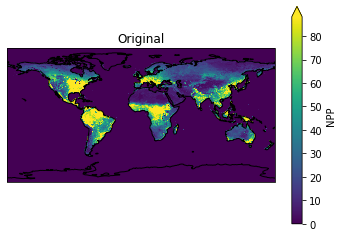

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.PlateCarree())
ds_in.isel(year=0, month=8).NPP.plot.pcolormesh(ax=ax, robust=True)
ax.set_title('Original')
ax.coastlines();

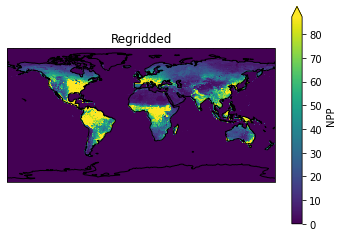

In [16]:
ax = plt.axes(projection=ccrs.PlateCarree())
dsregrid_out.isel(year=0, month=8).NPP.plot.pcolormesh(ax=ax, robust=True)
ax.set_title('Regridded')
ax.coastlines();

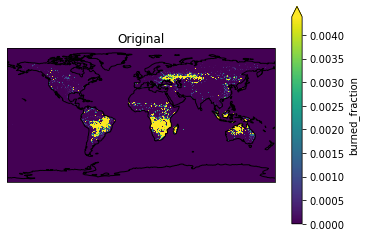

In [17]:
ax = plt.axes(projection=ccrs.PlateCarree())
ds_in.isel(year=0, month=8).burned_fraction.plot.pcolormesh(ax=ax, robust=True)
ax.set_title('Original')
ax.coastlines();

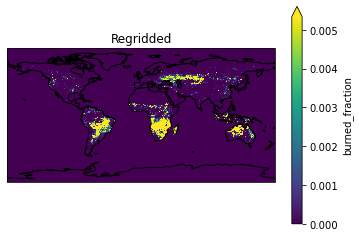

In [18]:
ax = plt.axes(projection=ccrs.PlateCarree())
dsregrid_out.isel(year=0, month=8).burned_fraction.plot.pcolormesh(ax=ax, robust=True)
ax.set_title('Regridded')
ax.coastlines();

## Set time to be a coordinate
use for selection and sorting by month vs year

In [19]:
regridded_out = dsregrid_out.stack(time=["year", "month"])
# view current time format
#regridded_out.time

In [20]:
# update time to be in yyyy-mm format
times = pd.date_range(start="1997-01", end="2016-12", freq='MS')
times

DatetimeIndex(['1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01',
               ...
               '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01',
               '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01',
               '2016-11-01', '2016-12-01'],
              dtype='datetime64[ns]', length=240, freq='MS')

In [21]:
regridded_out = regridded_out.assign_coords(time=times)
#regridded_out

## Store regrid file

In [ ]:
# store global regrid file
#fout_gfed = '/project/tss/jkshuman/obs/GFED4/regrid_GFED4_1degree_1997-2016.nc'
#regridded_out.to_netcdf(path=fout_gfed)

## Select region of interest

Using SREX Regions (Special Report on Managing the Risks of Extreme Events and Disasters to Advance Climate Change Adaptation (SREX) from Seneviratne et al., 2012): https://regionmask.readthedocs.io/en/stable/defined_scientific.html#srex-regions

In [22]:
output_mask = regionmask.defined_regions.srex.mask(regridded_out, lon_name="lon", lat_name="lat")
output_mask

<xarray.DataArray 'region' (lat: 199, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -89.0 -88.1 -87.2 -86.3 -85.4 ... 86.5 87.4 88.3 89.2
  * lon      (lon) float64 -179.0 -177.8 -176.5 -175.2 ... 177.2 178.5 179.8

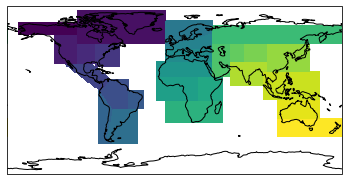

In [23]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
ax.set_global()

output_mask.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, label=True);

In [24]:
regionmask.defined_regions.srex.names

['Alaska/N.W. Canada',
 'Canada/Greenl./Icel.',
 'W. North America',
 'C. North America',
 'E. North America',
 'Central America/Mexico',
 'Amazon',
 'N.E. Brazil',
 'Coast South America',
 'S.E. South America',
 'N. Europe',
 'C. Europe',
 'S. Europe/Mediterranean',
 'Sahara',
 'W. Africa',
 'E. Africa',
 'S. Africa',
 'N. Asia',
 'W. Asia',
 'C. Asia',
 'Tibetan Plateau',
 'E. Asia',
 'S. Asia',
 'S.E. Asia',
 'N. Australia',
 'S. Australia/New Zealand']

ValueError: zero-size array to reduction operation minimum which has no identity

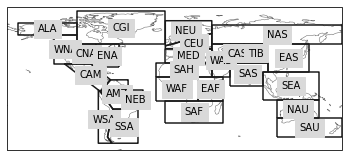

In [25]:
regionmask.defined_regions.srex.plot(label='abbrev');
plt.tight_layout()

In [27]:
# We want to select the following regions for south america
regions_of_interest = ['Central America/Mexico','Amazon', 'N.E. Brazil',
                       'Coast South America','S.E. South America',]

# Thus we first need to find out which numbers these are:
indexes = [regionmask.defined_regions.srex.map_keys(region) for region in regions_of_interest]
indexes

[6, 7, 8, 9, 10]

In [28]:
input_mask = regionmask.defined_regions.srex.mask(ds_in, lon_name="lon", lat_name="lat")
input_mask

<xarray.DataArray 'region' (lat: 720, lon: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 89.875 89.625 89.375 ... -89.375 -89.625 -89.875
  * lon      (lon) float32 -179.875 -179.625 -179.375 ... 179.625 179.875

In [29]:
# mask for original data that matches indices for regions_of_interest
ds_in_msk = ds_in.where(input_mask.isin(indexes), drop=True)
ds_in_msk = ds_in_msk.assign_coords(time=times)
#ds_in_msk

In [30]:
# mask for regrid data that matches indices for regions_of_interest
regrid_out_msk = regridded_out.where(output_mask.isin(indexes), drop=True)
regrid_out_msk = regrid_out_msk.assign_coords(time=times)
#regrid_out_msk

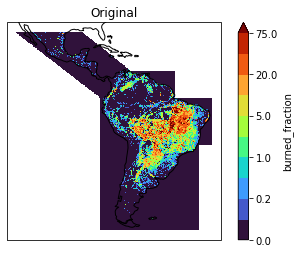

In [31]:
cmap='turbo' 
bounds = [0,0.1,0.2,0.5,1.,2.,5.,10.,20.,50.,75.]
ax = plt.axes(projection=ccrs.PlateCarree())
ds_in_msk = ds_in_msk*12*100
ds_in_msk.isel(year=0,month=8).burned_fraction.plot.pcolormesh(ax=ax,robust=True,
                                                             cmap=cmap, levels=bounds)
ax.set_title('Original')
ax.coastlines();

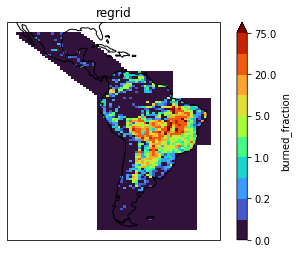

In [32]:
cmap='turbo' 
bounds = [0,0.1,0.2,0.5,1.,2.,5.,10.,20.,50.,75.]
ax = plt.axes(projection=ccrs.PlateCarree())
regrid_out_msk_test = regrid_out_msk*12*100
regrid_out_msk_test.sel(time='1997-09-01').burned_fraction.plot.pcolormesh(ax=ax,robust=True,
                                                             cmap=cmap, levels=bounds)
ax.set_title('regrid')
ax.coastlines();

## South America Custom region
- Path to domain file

In [33]:
# path to tropics domain file within same folder as the data
domain = xr.open_dataset('/home/jkshuman/sfcdata/domain.lnd.fv0.9x1.25_gx1v6.SA.nc')
#domain = xr.open_dataset('domain_processed_GFED4s-burnedArea.nc')
domain

<xarray.Dataset>
Dimensions:  (ni: 45, nj: 58, nv: 4)
Dimensions without coordinates: ni, nj, nv
Data variables:
    yc       (nj, ni) float64 ...
    xc       (nj, ni) float64 ...
    yv       (nj, ni, nv) float64 ...
    xv       (nj, ni, nv) float64 ...
    mask     (nj, ni) int32 ...
    area     (nj, ni) float64 ...
    frac     (nj, ni) float64 ...
Attributes:
    creation_date:  180501
    source_file:    /glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd...
    title:          CESM domain data

### Input Grid for region
- pull size of region (height=nj,width=ni) and coords xv,yv
- create empty grid for subset
- subset lats,lons from regional domain 
- provide corner coordinates
- select lat,lon inside region of interest

In [34]:
# pull coords of region
ni = domain.ni.data
nj = domain.nj.data
lon = domain.xc.data
lat = domain.yc.data
#define width and height of the target arrays (match domain size)
width = len(ni)
height = len(nj)

# --  Create vertex matrices  ----------------------------
lonv=np.full((height,width),np.nan)
latv=np.full((height,width),np.nan)

# pull coord vertices for custom region
lonS = lon.min()
lonN = lon.max()
latW = lat.min()
latE = lat.max()

## coords for South America
    #if tagnum == 2: # S.America
    #    ln1=275. = -85
    #    ln2=330. = -30
    #    lt1=-40.
    #    lt2=15.

# convert to -180 to 180
if (lonS > 180):
    lonS = lonS-360
if (lonN > 180):
    lonN = lonN-360

# name and create array for region mask vertices    
SAmer_mask = np.array([[lonS,latW],[lonN,latW],[lonN,latE],[lonS,latE]])
SAmer_mask

array([[-85.        , -39.10994764],
       [-30.        , -39.10994764],
       [-30.        ,  14.60732984],
       [-85.        ,  14.60732984]])

In [35]:
names= ["South_America"]
abbrevs = ["SAmer"]
SAregion = regionmask.Regions([SAmer_mask], names=names, abbrevs=abbrevs, name="SAmerica")
SAregion

<regionmask.Regions>
Name:     SAmerica

Regions:
 0  SAmer  South_America

[1 regions]

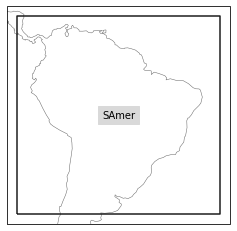

In [36]:
ax = SAregion.plot(label="abbrev")

# Mask data for custom region
- create grid with nulls outside of lat and lon of region
- select only points in this region, drop others

In [37]:
# mask for original data
# grid with nulls outside of mask
mask_SA = SAregion.mask(ds_in)
ds_in_SA = ds_in.where(mask_SA.notnull(),drop=True)
ds_in_SA

<xarray.Dataset>
Dimensions:          (lat: 214, lon: 220, month: 12, year: 20)
Coordinates:
    basis_regions    (lat, lon) uint8 dask.array<chunksize=(214, 220), meta=np.ndarray>
  * lat              (lat) float32 14.375 14.125 13.875 ... -38.625 -38.875
  * lon              (lon) float32 -84.875 -84.625 -84.375 ... -30.375 -30.125
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * year             (year) int64 1997 1998 1999 2000 ... 2013 2014 2015 2016
Data variables:
    NPP              (year, month, lat, lon) float32 dask.array<chunksize=(1, 12, 214, 220), meta=np.ndarray>
    burned_fraction  (year, month, lat, lon) float32 dask.array<chunksize=(1, 12, 214, 220), meta=np.ndarray>

In [38]:
# mask for regrid data
# grid with nulls outside of mask
mask_SA = SAregion.mask(regridded_out)
regrid_out_SA = regridded_out.where(mask_SA.notnull(),drop=True)
#regrid_out_SA

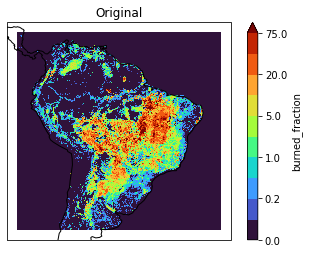

In [39]:
cmap='turbo' 
bounds = [0,0.1,0.2,0.5,1.,2.,5.,10.,20.,50.,75.]
ax = plt.axes(projection=ccrs.PlateCarree())
ds_in_SA = ds_in_SA*12*100
ds_in_SA.isel(year=0,month=8).burned_fraction.plot.pcolormesh(ax=ax,robust=True,
                                                             cmap=cmap, levels=bounds)
ax.set_title('Original')
ax.coastlines();

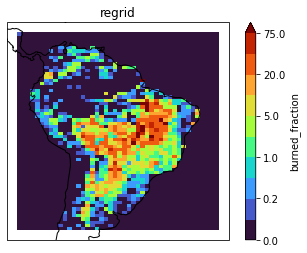

In [40]:
cmap='turbo' 
bounds = [0,0.1,0.2,0.5,1.,2.,5.,10.,20.,50.,75.]
ax = plt.axes(projection=ccrs.PlateCarree())
regrid_out_SA_test = regrid_out_SA*12*100
regrid_out_SA_test.sel(time='1997-09-01').burned_fraction.plot.pcolormesh(ax=ax,robust=True,
                                                             cmap=cmap, levels=bounds)
ax.set_title('regrid')
ax.coastlines();

In [41]:
ds_in_SA.mean().compute()

<xarray.Dataset>
Dimensions:          ()
Data variables:
    NPP              float32 40597.914
    burned_fraction  float32 0.91219974

In [42]:
regrid_out_SA_test
regrid_out_SA_test.mean()

<xarray.Dataset>
Dimensions:          ()
Data variables:
    NPP              float64 4.029e+04
    burned_fraction  float64 0.9225